# Hybrid Quantum Neural Networks

The example below highlights a hybrid quantum neural network workflow with CUDA-Q and PyTorch where both layers can GPU accelerated to maximise performance.

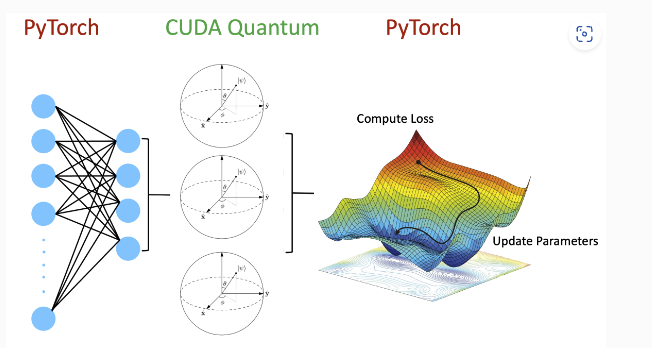

We perform binary classification on the MNIST dataset where data flows through the neural network architecture to the quantum circuit whose output is used to classify hand written digits.

In [4]:
!pip install scikit-learn==1.4.2

Defaulting to user installation because normal site-packages is not writeable
ERROR: Ignored the following versions that require a different python version: 1.4.0 Requires-Python >=3.9; 1.4.0rc1 Requires-Python >=3.9; 1.4.1.post1 Requires-Python >=3.9; 1.4.2 Requires-Python >=3.9; 1.5.0 Requires-Python >=3.9; 1.5.0rc1 Requires-Python >=3.9
ERROR: Could not find a version that satisfies the requirement scikit-learn==1.4.2 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.1, 1.2.2, 1.3.0rc1, 1.3.0, 1.3.1, 1.3.2)
ERROR: No matching distribution found for scikit-learn==1.4.2

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run

In [1]:
# Import the relevant packages.

!pip install matplotlib==3.8.4
!pip install torch==2.2.2
!pip install torchvision==0.17.0
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
ERROR: Ignored the following versions that require a different python version: 3.8.0 Requires-Python >=3.9; 3.8.0rc1 Requires-Python >=3.9; 3.8.1 Requires-Python >=3.9; 3.8.2 Requires-Python >=3.9; 3.8.3 Requires-Python >=3.9; 3.8.4 Requires-Python >=3.9; 3.9.0 Requires-Python >=3.9; 3.9.0rc2 Requires-Python >=3.9
ERROR: Could not find a version that satisfies the requirement matplotlib==3.8.4 (from versions: 0.86, 0.86.1, 0.86.2, 0.91.0, 0.91.1, 1.0.1, 1.1.0, 1.1.1, 1.2.0, 1.2.1, 1.3.0, 1.3.1, 1.4.0, 1.4.1rc1, 1.4.1, 1.4.2, 1.4.3, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 2.0.0b1, 2.0.0b2, 2.0.0b3, 2.0.0b4, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.0.1, 2.0.2, 2.1.0rc1, 2.1.0, 2.1.1, 2.1.2, 2.2.0rc1, 2.2.0, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 3.0.0rc2, 3.0.0, 3.0.1, 3.0.2, 3.0.3, 3.1.0rc1, 3.1.0rc2, 3.1.0, 3.1.1, 3.1.2, 3.1.3, 3.2.0rc1, 3.2.0rc3, 3.2.0, 3.2.1, 3.2.2, 3.3.0rc1, 3.3.0, 3.3.1, 3.3.2, 3.3.3, 3.3.4, 3.4.0rc1, 3.4.0rc2, 3.4.0rc3, 3

In [2]:

import cudaq
from cudaq import spin

import matplotlib.pyplot as plt

import numpy as np

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torchvision

from sklearn.model_selection import train_test_split

torch.manual_seed(22)
cudaq.set_random_seed(44)

In [9]:
# Set CUDAQ and PyTorch to run on either CPU or GPU.

device = torch.device('cpu')
cudaq.set_target("qpp-cpu")

# cudaq.set_target("nvidia")
# device = torch.device("cuda:0")
# device

In [11]:
def prepare_data(target_digits, sample_count, test_size):
    """Load and prepare the MNIST dataset to be used 
    
    Args: 
        target_digits (list): digits to perform classification of 
        sample_count (int): total number of images to be used
        test_size (float): percentage of sample_count to be used as test set, the remainder is the training set
        
    Returns: 
        dataset in train, test format with targets 
    
    """

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307), (0.3081))])

    dataset = datasets.MNIST("./data",
                             train=True,
                             download=True,
                             transform=transform)

    # Filter out the required labels.
    idx = (dataset.targets == target_digits[0]) | (dataset.targets
                                                   == target_digits[1])
    dataset.data = dataset.data[idx]
    dataset.targets = dataset.targets[idx]

    # Select a subset based on number of datapoints specified by sample_count.
    subset_indices = torch.randperm(dataset.data.size(0))[:sample_count]

    x = dataset.data[subset_indices].float().unsqueeze(1).to(device)

    y = dataset.targets[subset_indices].to(device).float().to(device)

    # Relabel the targets as a 0 or a 1.
    y = torch.where(y == min(target_digits), 0.0, 1.0)

    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size=test_size /
                                                        100,
                                                        shuffle=True,
                                                        random_state=42)

    return x_train, x_test, y_train, y_test

In [12]:
# Classical parameters.

sample_count = 1000  # Total number of images to use.
target_digits = [5, 6]  # Hand written digits to classify.
test_size = 30  # Percentage of dataset to be used for testing.
classification_threshold = 0.5  # Classification boundary used to measure accuracy.
epochs = 1000  # Number of epochs to train for.

# Quantum parmeters.

qubit_count = 1
hamiltonian = spin.z(0)  # Measurement operator.
shift = torch.tensor(torch.pi / 2)  # Magnitude of parameter shift.

In [13]:
x_train, x_test, y_train, y_test = prepare_data(target_digits, sample_count,
                                                test_size)

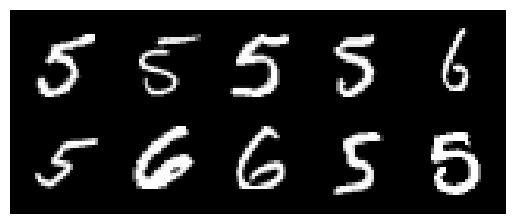

In [14]:
# Plot some images from the training set to visualise.

grid_img = torchvision.utils.make_grid(x_train[:10],
                                       nrow=5,
                                       padding=3,
                                       normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')  
plt.show()

In [15]:
class QuantumFunction(Function):
    """Allows the quantum circuit to input data, output expectation values 
    and calculate gradients of variational parameters via finite difference"""

    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator):
        """Define the quantum circuit in CUDA Quantum"""

        @cudaq.kernel
        def kernel(qubit_count: int, thetas: np.ndarray):

            qubits = cudaq.qvector(qubit_count)

            ry(thetas[0], qubits[0])
            rx(thetas[1], qubits[0])

        self.kernel = kernel
        self.qubit_count = qubit_count
        self.hamiltonian = hamiltonian

    def run(self, theta_vals: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""

        #If running on GPU, thetas is a torch.tensor that will live on GPU memory. The observe function calls a .tolist() method on inputs which moves thetas from GPU to CPU.

        qubit_count = [self.qubit_count for _ in range(theta_vals.shape[0])]

        results = cudaq.observe(self.kernel, self.hamiltonian, qubit_count,
                                theta_vals)

        exp_vals = [results[i].expectation() for i in range(len(results))]
        exp_vals = torch.Tensor(exp_vals).to(device)

        return exp_vals

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:

        # Save shift and quantum_circuit in context to use in backward.
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Calculate expectation value.
        exp_vals = ctx.quantum_circuit.run(thetas).reshape(-1, 1)

        ctx.save_for_backward(thetas, exp_vals)

        return exp_vals

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference"""

        thetas, _ = ctx.saved_tensors

        gradients = torch.zeros(thetas.shape, device=device)

        for i in range(thetas.shape[1]):

            thetas_plus = thetas.clone()
            thetas_plus[:, i] += ctx.shift
            exp_vals_plus = ctx.quantum_circuit.run(thetas_plus)

            thetas_minus = thetas.clone()
            thetas_minus[:, i] -= ctx.shift
            exp_vals_minus = ctx.quantum_circuit.run(thetas_minus)

            gradients[:, i] = (exp_vals_plus - exp_vals_minus) / (2 * ctx.shift)

        gradients = torch.mul(grad_output, gradients)

        return gradients, None, None

In [16]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit into a quantum layer adhering PyTorch convention"""

    def __init__(self, qubit_count: int, hamiltonian, shift: torch.tensor):
        super(QuantumLayer, self).__init__()

        self.quantum_circuit = QuantumFunction(qubit_count, hamiltonian)
        self.shift = shift

    def forward(self, input):

        result = QuantumFunction.apply(input, self.quantum_circuit, self.shift)

        return result

In [17]:
class Hyrbid_QNN(nn.Module):
    """Structure of the hybrid neural network with classical fully connected layers and quantum layers"""

    def __init__(self):
        super(Hyrbid_QNN, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(0.25)

        # The 2 outputs from PyTorch fc5 layer feed into the 2 variational gates in the quantum circuit.
        self.quantum = QuantumLayer(qubit_count, hamiltonian, shift)

    def forward(self, x):

        x = x.view(-1, 28 * 28)  # Turns images into vectors.

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)

        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)

        # Quantum circuit outputs an expectation value which is fed into the sigmoid activation function to perform classification.
        x = torch.sigmoid(self.quantum(x))

        return x.view(-1)

In [18]:
def accuracy_score(y, y_hat):
    return sum((y == (y_hat >= classification_threshold))) / len(y)

In [19]:
hybrid_model = Hyrbid_QNN().to(device)

optimizer = optim.Adadelta(hybrid_model.parameters(),
                           lr=0.001,
                           weight_decay=0.8)

loss_function = nn.BCELoss().to(device)

training_cost = []
testing_cost = []
training_accuracy = []
testing_accuracy = []

hybrid_model.train()
for epoch in range(epochs):

    optimizer.zero_grad()

    y_hat_train = hybrid_model(x_train).to(device)

    train_cost = loss_function(y_hat_train, y_train).to(device)

    train_cost.backward()

    optimizer.step()

    training_accuracy.append(accuracy_score(y_train, y_hat_train))
    training_cost.append(train_cost.item())

    hybrid_model.eval()
    with torch.no_grad():

        y_hat_test = hybrid_model(x_test).to(device)

        test_cost = loss_function(y_hat_test, y_test).to(device)

        testing_accuracy.append(accuracy_score(y_test, y_hat_test))
        testing_cost.append(test_cost.item())

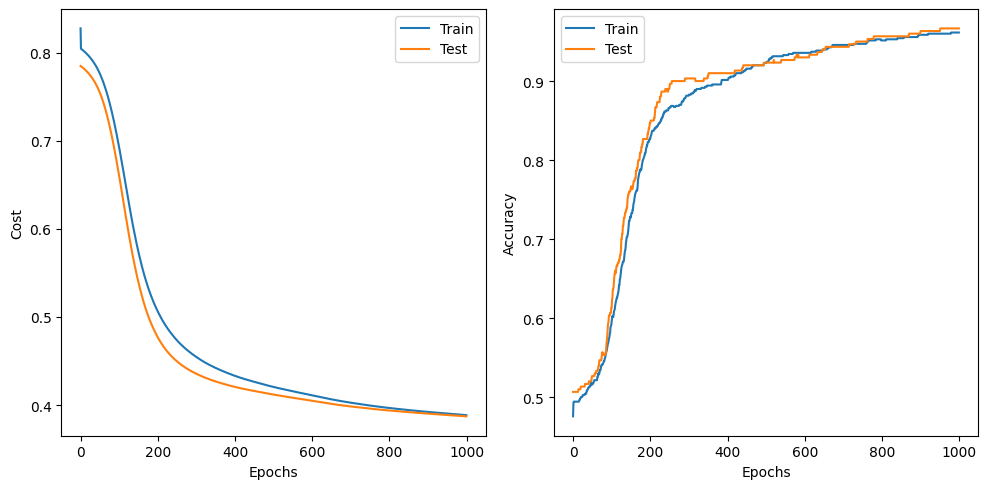

In [20]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_cost, label='Train')
plt.plot(testing_cost, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Train')
plt.plot(testing_accuracy, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
print(cudaq.__version__)

CUDA-Q Version 0.7.1 (https://github.com/NVIDIA/cuda-quantum 1f8dd79d46cad9b9bd0eb220eb04408a2e6beda4)
